# CIFAR10 com Multilayer Perceptron (MLP)


> Este projeto tem como objetivo desenvolver e otimizar uma Rede Neural Multicamadas (**MLP - Multilayer Perceptron**) para a tarefa de classificação de imagens utilizando o dataset CIFAR-10.

Ao longo do notebook, vamos utilizar o **optuna** para testar vários hyperparâmetros com o objetivo de entender melhor como eles se relacionam, afim de, melhorar a acurácia do modelo.


# Otimizações

Para alcançar melhores resultados e extrair o máximo desempenho do modelo, serão aplicadas diversas estratégias de aprimoramento. Isso inclui a experimentação com diferentes otimizadores **(como Adam, SGD, AdamW)**, funções de ativação **(ReLU, Sigmoid, leaky_relu e elu)**, e técnicas de regularização **(Dropout)** para reduzir o overfitting. Além disso, será utilizado um conjunto de validação separado para monitorar as métricas ao longo do treinamento e tomar decisões mais assertivas durante o ajuste dos hiperparâmetros. O projeto também contará com a aplicação do Optuna, uma poderosa ferramenta de otimização automática de hiperparâmetros, que permitirá explorar de forma eficiente combinações de configurações que maximizem o desempenho da MLP.

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 19.7 MB/s eta 0:00:00


# Pré-processamento

> Para melhorar a capacidade de generalização do modelo, foram aplicadas técnicas de data augmentation apenas nos dados de treino.

As transformações utilizadas:

1. **RandomHorizontalFlip**: Gira horizontalmente a imagem com 50% de chance. Ajuda o modelo a não depender da orientação original dos objetos.
2. **RandomRotation**: Rotaciona a imagem em até ±10°. Simula ângulos diferentes de visão.
3. **ColorJitter**: Altera brilho, contraste, saturação e matiz. Faz o modelo aprender com variações de iluminação.

> Essas variações simulam diferentes condições visuais, tornando o modelo mais robusto a mudanças no ambiente. Nos dados de teste, foi aplicada apenas a normalização, preservando sua integridade para uma avaliação justa.



In [ ]:
#@title 1. Definindo as bibliotecas utilizadas

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from sklearn import metrics
from tqdm import tqdm
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#@title 2. Configurando ambiente
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_transforms():
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    return train_transform, test_transform

# MLP com regularização

> No modelo abaixo, utilizaremos a técnica de **Dropout**, que desativa aleatoriamente parte dos neurônios durante o treino, incentivando a rede a aprender representações mais robustas.

In [ ]:
class MLPRegularization(nn.Module):
    def __init__(
        self,
        input_size,
        num_classes,
        hidden_sizes=[64, 128, 64],
        activation='relu',
        dropout_rate=0.5
    ):
        super(MLPRegularization, self).__init__()

        self.activations = {
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'leaky_relu': nn.LeakyReLU(0.01),
            'elu': nn.ELU(),
        }

        self.activation = self.activations[activation]

        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))

            layers.append(self.activation)

            layers.append(nn.Dropout(dropout_rate))

            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, num_classes))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [ ]:
#@title 3. CLASSE PARA TREINAMENTO COM VALIDAÇÃO
class MLPTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device

        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def train_epoch(self, optimizer, criterion):
        """Treina uma época"""
        self.model.train()
        total_loss = 0.0
        correct = 0
        total = 0

        for images, labels in self.train_loader:
            images = images.view(images.size(0), -1).to(self.device)
            labels = labels.to(self.device)

            optimizer.zero_grad()
            outputs = self.model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_loss = total_loss / len(self.train_loader)
        accuracy = 100 * correct / total

        return avg_loss, accuracy

    def validate(self, criterion):
        """Avalia no conjunto de validação"""
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in self.val_loader:
                images = images.view(images.size(0), -1).to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(images)
                loss = criterion(outputs, labels)

                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_loss = total_loss / len(self.val_loader)
        accuracy = 100 * correct / total

        return avg_loss, accuracy

    def train(self, optimizer, criterion, num_epochs, patience=10):
        """Loop de treinamento completo"""
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in tqdm(range(num_epochs), desc="Treinando"):
            # Treinar
            train_loss, train_acc = self.train_epoch(optimizer, criterion)

            # Validar
            val_loss, val_acc = self.validate(criterion)

            # Salvar histórico
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Salvar melhor modelo
                torch.save(self.model.state_dict(), 'best_model.pth')
            else:
                patience_counter += 1

            if epoch % 10 == 0:
                print(f'Época {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
                      f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

            if patience_counter >= patience:
                print(f"Early stopping na época {epoch}")
                break

        self.model.load_state_dict(torch.load('best_model.pth'))
        return self.model

    def evaluate(self):
        """Avaliação final no conjunto de teste"""
        self.model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in self.test_loader:
                images = images.view(images.size(0), -1).to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        return self.get_scores(all_labels, all_preds)

    def get_scores(self, targets, predictions):
        """Calcula métricas de avaliação"""
        return {
            "accuracy": metrics.accuracy_score(targets, predictions),
            "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
            "precision": metrics.precision_score(targets, predictions, average="weighted"),
            "recall": metrics.recall_score(targets, predictions, average="weighted"),
            "f1_score": metrics.f1_score(targets, predictions, average="weighted")
        }

    def plot_training_history(self):
        """Plota gráficos de treinamento"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # Loss
        ax1.plot(self.train_losses, label='Train Loss')
        ax1.plot(self.val_losses, label='Validation Loss')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()

        # Accuracy
        ax2.plot(self.train_accuracies, label='Train Accuracy')
        ax2.plot(self.val_accuracies, label='Validation Accuracy')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()

        plt.tight_layout()
        plt.show()

In [ ]:
#@title 4. OTIMIZAÇÃO DE HIPERPARÂMETROS COM OPTUNA
def objective(trial):

    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
    hidden_size_1 = trial.suggest_int("hidden_size_1", 32, 256)
    hidden_size_2 = trial.suggest_int("hidden_size_2", 64, 512)
    hidden_size_3 = trial.suggest_int("hidden_size_3", 32, 256)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.7)
    activation = trial.suggest_categorical("activation", ["relu", "sigmoid", "leaky_relu", "elu"])
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "sgd", "adamw"])

    train_transform, test_transform = get_transforms()

    full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                      download=True, transform=train_transform)

    train_size = int(0.8 * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = MLPRegularization(
        input_size=32*32*3,
        num_classes=10,
        hidden_sizes=[hidden_size_1, hidden_size_2, hidden_size_3],
        activation=activation,
        dropout_rate=dropout_rate
    )

    if optimizer_name == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:  # adamw
        optimizer = optim.AdamW(model.parameters(), lr=lr)

    criterion = nn.CrossEntropyLoss()

    trainer = MLPTrainer(model, train_loader, val_loader, None, device)

    best_val_acc = 0
    for epoch in range(20):
        train_loss, train_acc = trainer.train_epoch(optimizer, criterion)
        val_loss, val_acc = trainer.validate(criterion)

        if val_acc > best_val_acc:
            best_val_acc = val_acc

        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_val_acc



1. Preparando dados...


100%|██████████| 170M/170M [00:12<00:00, 13.6MB/s]
[I 2025-06-01 22:32:57,564] A new study created in memory with name: no-name-09c0ea4b-1ef7-4f55-b4c0-732085618ca2


Tamanhos dos conjuntos - Treino: 40000, Validação: 10000, Teste: 10000

2. Otimizando hiperparâmetros...


[I 2025-06-01 22:49:31,934] Trial 0 finished with value: 26.62 and parameters: {'lr': 0.002780529554220144, 'batch_size': 16, 'hidden_size_1': 216, 'hidden_size_2': 276, 'hidden_size_3': 247, 'dropout_rate': 0.42353525689757776, 'activation': 'leaky_relu', 'optimizer': 'adamw'}. Best is trial 0 with value: 26.62.
[I 2025-06-01 23:04:00,965] Trial 1 finished with value: 25.01 and parameters: {'lr': 0.005230379368758396, 'batch_size': 128, 'hidden_size_1': 35, 'hidden_size_2': 430, 'hidden_size_3': 83, 'dropout_rate': 0.5235672391358591, 'activation': 'relu', 'optimizer': 'adamw'}. Best is trial 0 with value: 26.62.
[I 2025-06-01 23:20:33,527] Trial 2 finished with value: 52.96 and parameters: {'lr': 0.0003426013958103395, 'batch_size': 16, 'hidden_size_1': 170, 'hidden_size_2': 155, 'hidden_size_3': 155, 'dropout_rate': 0.15748955485971802, 'activation': 'leaky_relu', 'optimizer': 'adamw'}. Best is trial 2 with value: 52.96.
[I 2025-06-01 23:35:57,422] Trial 3 finished with value: 35.14

Melhores hiperparâmetros:
  lr: 0.0003426013958103395
  batch_size: 16
  hidden_size_1: 170
  hidden_size_2: 155
  hidden_size_3: 155
  dropout_rate: 0.15748955485971802
  activation: leaky_relu
  optimizer: adamw

3. Treinamento final...


Treinando:   2%|▏         | 1/50 [00:49<40:05, 49.08s/it]

Época 0: Train Loss: 1.8178, Val Loss: 1.6673, Train Acc: 34.90%, Val Acc: 41.05%


Treinando:  22%|██▏       | 11/50 [09:01<32:02, 49.28s/it]

Época 10: Train Loss: 1.4194, Val Loss: 1.3795, Train Acc: 50.04%, Val Acc: 50.75%


Treinando:  42%|████▏     | 21/50 [17:21<24:24, 50.51s/it]

Época 20: Train Loss: 1.3348, Val Loss: 1.3458, Train Acc: 52.48%, Val Acc: 52.83%


Treinando:  62%|██████▏   | 31/50 [25:46<15:57, 50.39s/it]

Época 30: Train Loss: 1.2859, Val Loss: 1.3278, Train Acc: 54.42%, Val Acc: 53.33%


Treinando:  82%|████████▏ | 41/50 [34:10<07:35, 50.60s/it]

Época 40: Train Loss: 1.2516, Val Loss: 1.2947, Train Acc: 55.90%, Val Acc: 54.68%


Treinando: 100%|██████████| 50/50 [41:44<00:00, 50.08s/it]



4. Avaliação final...

=== RESULTADOS FINAIS ===
ACCURACY: 0.5607
BALANCED_ACCURACY: 0.5607
PRECISION: 0.5598
RECALL: 0.5607
F1_SCORE: 0.5575

5. Gerando gráficos...


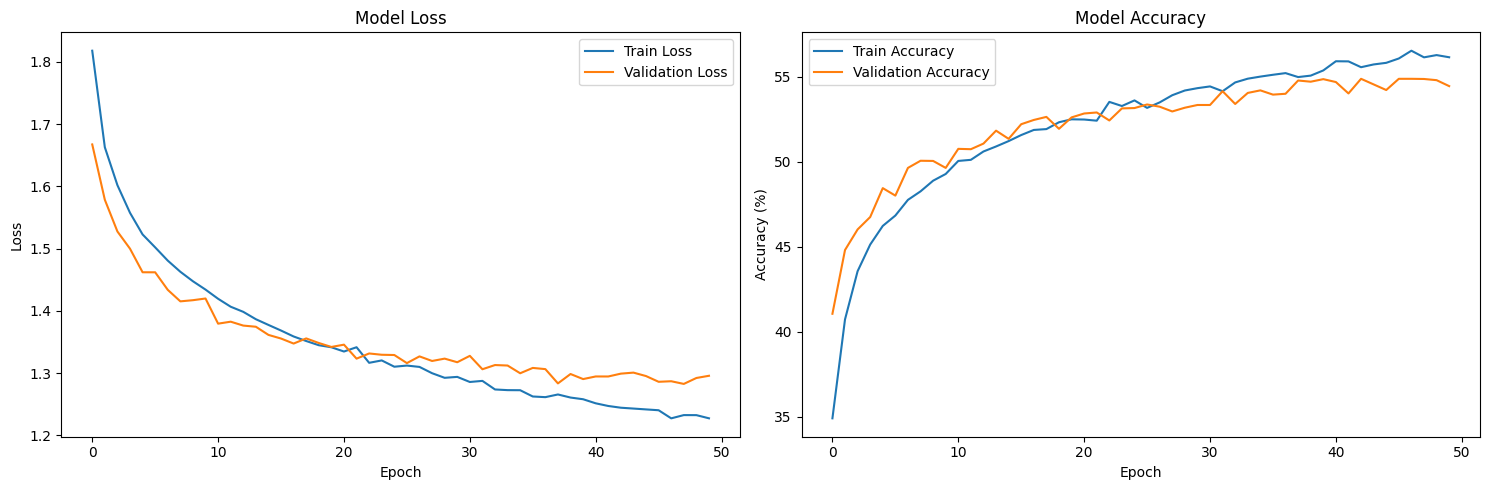

In [ ]:
def main():
    print("1. Preparando dados...")
    train_transform, test_transform = get_transforms()

    full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                      download=True, transform=train_transform)
    test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                               download=True, transform=test_transform)

    # Dividir treino em treino e validação (80-20)
    train_size = int(0.8 * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    print(f"Tamanhos dos conjuntos - Treino: {len(train_dataset)}, Validação: {len(val_dataset)}, Teste: {len(test_dataset)}")


    print("\n2. Otimizando hiperparâmetros...")
    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
    study.optimize(objective, n_trials=5)

    print("Melhores hiperparâmetros:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")

    best_params = study.best_params

    print("\n3. Treinamento final...")

    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

    model = MLPRegularization(
        input_size=32*32*3,
        num_classes=10,
        hidden_sizes=[best_params['hidden_size_1'], best_params['hidden_size_2'], best_params['hidden_size_3']],
        activation=best_params['activation'],
        dropout_rate=best_params['dropout_rate']
    )

    # Otimizador
    if best_params['optimizer'] == "adam":
        optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
    elif best_params['optimizer'] == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=best_params['lr'], momentum=0.9, weight_decay=1e-4)
    else:
        optimizer = optim.AdamW(model.parameters(), lr=best_params['lr'], weight_decay=1e-4)

    criterion = nn.CrossEntropyLoss()

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

    trainer = MLPTrainer(model, train_loader, val_loader, test_loader, device)
    trained_model = trainer.train(optimizer, criterion, num_epochs=50, patience=15)

    print("\n4. Avaliação final...")
    final_scores = trainer.evaluate()

    print("\n=== RESULTADOS FINAIS ===")
    for metric, score in final_scores.items():
        print(f"{metric.upper()}: {score:.4f}")

    print("\n5. Gerando gráficos...")
    trainer.plot_training_history()

    return trained_model, trainer

if __name__ == "__main__":
    model, trainer = main()